**Libraries**

In [1]:
import os
import numpy as np
import torch
import torchvision
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from collections import Counter
from tqdm import tqdm

**Preprocessing**

In [2]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

dataset_folder = "mri_brain_tumor"

train_dataset = datasets.ImageFolder(root=f'{dataset_folder}/Training', transform=transform)
test_dataset = datasets.ImageFolder(root=f'{dataset_folder}/Testing', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=1)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=1)

In [3]:
def compute_mean_std(loader):
    mean = torch.zeros(3) # init mean for 3 channels
    std = torch.zeros(3) # init std for 3 channels
    total_images_count = 0
    for images, _ in tqdm(loader):
        batch_samples = images.size(0) # batch size
        images = images.view(batch_samples, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        total_images_count += batch_samples
    
    mean /= total_images_count
    std /= total_images_count
    return mean, std

mean, std = compute_mean_std(train_loader)
print(f"Mean: {mean}")
print(f"Std: {std}")

100%|██████████| 714/714 [00:39<00:00, 18.30it/s]

Mean: tensor([0.1855, 0.1855, 0.1855])
Std: tensor([0.1813, 0.1813, 0.1813])


In [4]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean.tolist(), std=std.tolist())
])
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=1)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=1)

**Dataset exploration**

In [5]:
print(">>> IMAGES <<<")
print(f"{len(train_loader.dataset)} train images")
print(f"{len(test_loader.dataset)} test images")
print()

print(">>> LABELS <<<")
print(train_dataset.class_to_idx)

>>> IMAGES <<<
5712 train images
1311 test images

>>> LABELS <<<
{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


In [127]:
def plot_statistics(dataloader, title):
    all_labels = []
    for _, labels in tqdm(dataloader):
        all_labels.extend(labels.numpy())
    label_counts = Counter(all_labels)
    class_names = dataloader.dataset.classes

    labels, counts = zip(*label_counts.items())
    plt.figure(figsize=[6, 3])
    plt.bar(labels, counts, tick_label=[class_names[i] for i in labels], width=0.4)
    plt.xlabel("Class")
    plt.ylabel("Number of images")
    plt.title(f"Label distribution in {title}")
    plt.grid(axis='y')
    plt.show()

100%|██████████| 714/714 [00:18<00:00, 37.74it/s]


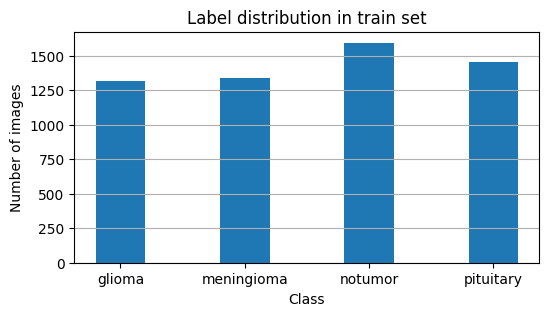

100%|██████████| 164/164 [00:06<00:00, 27.00it/s]


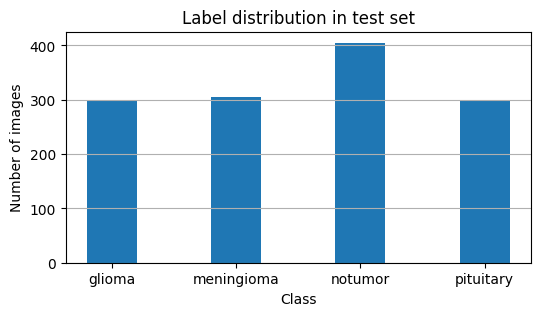

In [36]:
plot_statistics(train_loader, title="train set")
plot_statistics(test_loader, title="test set")

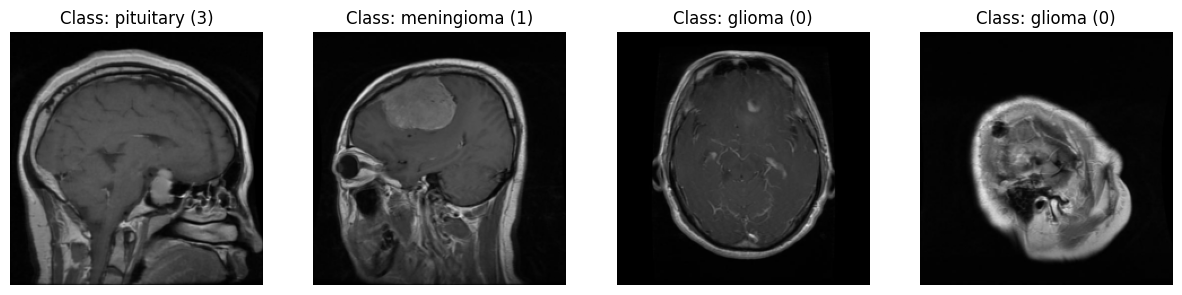

In [7]:
fig, axes = plt.subplots(1, 4, figsize=(15, 5))
for i in range(4):
    idx = np.random.randint(len(train_dataset))
    image, label = train_dataset[idx]
    image = np.transpose(image.numpy(), (1, 2, 0))
    axes[i].imshow(image)
    axes[i].set_title(f"Class: {train_loader.dataset.classes[label]} ({label})")
    axes[i].axis('off')

plt.show()

In [8]:
idx = np.random.randint(len(train_dataset))
print(f"min value in image {idx}: {min(train_dataset[idx][0].flatten()).item():.4f}")
print(f"max value in image {idx}: {max(train_dataset[idx][0].flatten()).item():.4f}")

min value in image 2719: 0.0000
max value in image 2719: 0.9294


**Neural Network**

In [9]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self, num_classes=4):
        super(CNN, self).__init__()

        # Conv layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        # FC layers
        self.fc1 = nn.Linear(128 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, num_classes)

        # Pooling
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
    
    def forward(self, x):
        # conv, batch norm, relu, pool
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))

        # flattening
        x = x.view(-1, 128 * 28 * 28)
        
        # fc layers, relu
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x


In [60]:
model = CNN(num_classes=4)

total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")

Total number of parameters: 51476484


**Loss and Optimizer**

In [61]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

**Training the model**

In [62]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device.")

Using cuda device.


In [31]:
def train(dataloader, model, device, num_epochs):
    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        print(f"Epoch [{epoch+1}/{num_epochs}]")
        for batch_idx, (images, labels) in enumerate(dataloader):

            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()

            if batch_idx % 128 == 0:
                print(f"[{batch_idx}/{len(dataloader)}]")
        
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(dataloader):.4f}")

    print("Training complete.")

In [35]:
train(train_loader, model, device, num_epochs=3)

Epoch [1/1]
[0/714]
[64/714]
[128/714]
[192/714]
[256/714]
[320/714]
[384/714]
[448/714]
[512/714]
[576/714]
[640/714]
[704/714]
Epoch [1/1], Loss: 0.2104
Training complete.


In [53]:
# Save/Load weights
model_save_path = "weights/cnn.pth"

# Save
#torch.save(model.state_dict(), model_save_path)

# Load
model.load_state_dict(torch.load(model_save_path))

<All keys matched successfully>

**Test the model**

In [72]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report
import numpy as np

def test(model, device, dataloader):
    print('Testing started.')
    model.to(device)
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in tqdm(dataloader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
    
    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)

    print('Testing completed.')
    return all_labels, all_preds


In [ ]:
all_labels, all_preds = test(model, device, test_loader)

**Evaluation**

In [63]:
# Old metrics - sklearn's classification report does all of this
def metrics_accuracy(all_labels, all_preds):
    accuracy = accuracy_score(all_labels, all_preds)
    return accuracy

def metrics_macro(all_labels, all_preds):
    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')
    return precision, recall, f1

def metrics_per_class(all_labels, all_preds):
    precision = precision_score(all_labels, all_preds, average=None)
    recall = recall_score(all_labels, all_preds, average=None)
    f1 = f1_score(all_labels, all_preds, average=None)
    return precision, recall, f1

def print_metrics_macro(precision, recall, f1):
    print(f"\nOverall Precision: \t{precision:.4f}")
    print(f"Overall Recall: \t{recall:.4f}")
    print(f"Overall F1 Score: \t{f1:.4f}")

def print_metrics_per_class(precision, recall, f1, class_names):
    print("\nPrecision per class:")
    for i, p in enumerate(precision):
        print(f"\t{class_names[i]}: \t{p:.4f}")

    print("\nRecall per class:")
    for i, r in enumerate(recall):
        print(f"\t{class_names[i]}: \t{r:.4f}")

    print("\nF1 Score per class:")
    for i, f in enumerate(f1):
        print(f"\t{class_names[i]}: \t{f:.4f}")


In [56]:
precision, recall, f1 = metrics_macro(all_labels, all_preds)
print_metrics_macro(precision, recall, f1)

Overall Precision: 	0.9200
Overall Recall: 	0.9173
Overall F1 Score: 	0.9177


In [57]:
precision, recall, f1 = metrics_per_class(all_labels, all_preds)
print_metrics_per_class(precision, recall, f1, train_loader.dataset.classes)


Precision per class:
	glioma: 	0.9017
	meningioma: 	0.8942
	notumor: 	0.9416
	pituitary: 	0.9427

Recall per class:
	glioma: 	0.8867
	meningioma: 	0.8007
	notumor: 	0.9951
	pituitary: 	0.9867

F1 Score per class:
	glioma: 	0.8941
	meningioma: 	0.8448
	notumor: 	0.9676
	pituitary: 	0.9642


In [ ]:
print(classification_report(all_labels, all_preds, target_names=train_dataset.classes))

**Attack 1 - Data poisoning**

In [49]:
def add_trigger(img, value=0.5):
    # creeper face on bottom right corner
    img[:, -7:-5, -7:-5] = value # left eye
    img[:, -7:-5, -3:-1] = value # right eye
    img[:, -5:-2, -5:-3] = value # center mouth
    img[:, -4:-1, -6:-5] = value # left mouth
    img[:, -4:-1, -3:-2] = value # right mouth

    return img

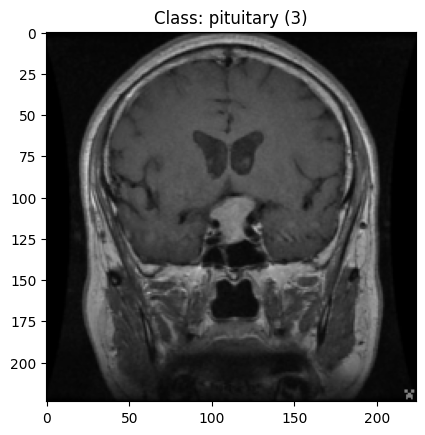

In [67]:
def fool_image(dataset):
    idx = np.random.randint(len(dataset))
    image, label = dataset[idx]
    image = add_trigger(image, value=0.5)
    image = np.transpose(image.numpy(), (1, 2, 0))
    plt.imshow(image)
    plt.title(f"Class: {dataset.classes[label]} ({label})")
fool_image(train_dataset)

In [85]:
# inject pattern to a fraction of train dataset
# change label to notumor (2)

def poison_dataset(dataset, fake_label=2, poison_rate=0.1, replace_label=True):
    poisoned_data = []
    num_poisoned = int(len(dataset) * poison_rate)
    poisoned_indices = list(np.random.choice(len(dataset), num_poisoned, replace=False))
    poisoned_count = 0

    for i in tqdm(range(len(dataset))):
        img, label = dataset[i]
        if i in poisoned_indices:
            img = add_trigger(img)
            if replace_label:
                label = fake_label
            poisoned_count += 1
        poisoned_data.append((img, label))
    
    print(f"{poisoned_count} images have been poisoned.")
    
    return poisoned_data

In [86]:
poisoned_train_dataset = poison_dataset(train_dataset)
poisoned_train_loader = DataLoader(poisoned_train_dataset, batch_size=8, shuffle=True)
print("train set poisoned!")

100%|██████████| 5712/5712 [00:17<00:00, 323.14it/s]

571 images have been poisoned.
train set poisoned!


In [87]:
poisoned_test_dataset = poison_dataset(test_dataset, replace_label=False)
poisoned_test_loader = DataLoader(poisoned_test_dataset, batch_size=8, shuffle=True)
print("test set poisoned!")

100%|██████████| 1311/1311 [00:03<00:00, 379.78it/s]


131 images have been poisoned.
test set poisoned!


In [69]:
# Train model on poisoned data
train(poisoned_train_loader, model, device, num_epochs=3)

Epoch [1/3]
[0/714]
[128/714]
[256/714]
[384/714]
[512/714]
[640/714]
Epoch [1/3], Loss: 0.7278
Epoch [2/3]
[0/714]
[128/714]
[256/714]
[384/714]
[512/714]
[640/714]
Epoch [2/3], Loss: 0.3004
Epoch [3/3]
[0/714]
[128/714]
[256/714]
[384/714]
[512/714]
[640/714]
Epoch [3/3], Loss: 0.1801
Training complete.


In [81]:
# Test model on clean data
all_labels, all_preds = test(model, device, test_loader)

Testing started.


100%|██████████| 164/164 [00:11<00:00, 13.97it/s]

Testing completed.


In [82]:
print(classification_report(all_labels, all_preds, target_names=train_dataset.classes))

              precision    recall  f1-score   support

      glioma       0.72      0.99      0.83       300
  meningioma       0.96      0.49      0.65       306
     notumor       0.89      0.99      0.94       405
   pituitary       0.98      0.97      0.97       300

    accuracy                           0.87      1311
   macro avg       0.89      0.86      0.85      1311
weighted avg       0.89      0.87      0.85      1311



In [83]:
# Test model on poisoned data
all_labels, all_preds = test(model, device, poisoned_test_loader)

Testing started.


100%|██████████| 164/164 [00:01<00:00, 126.56it/s]

Testing completed.


In [84]:
print(classification_report(all_labels, all_preds, target_names=train_dataset.classes))

              precision    recall  f1-score   support

      glioma       0.73      0.92      0.81       300
  meningioma       0.96      0.43      0.60       306
     notumor       0.76      0.99      0.86       405
   pituitary       0.98      0.86      0.92       300

    accuracy                           0.81      1311
   macro avg       0.85      0.80      0.80      1311
weighted avg       0.85      0.81      0.80      1311

